                 Model   Accuracy  F1_score  Inference_Time  Model_Size  \
2          Naive Bayes  95.774648  0.956879       61.522722    0.046875   
1                  SVM  95.372233  0.954092       62.474966    0.046875   
3        Random Forest  94.164990  0.943689       87.527514    0.046875   
0  Logistic Regression  95.171026  0.952941      119.832516    0.046875   

   TOPSIS_Score  Rank  
2      1.000000   1.0  
1      0.979406   2.0  
3      0.552260   3.0  
0      0.033645   4.0  


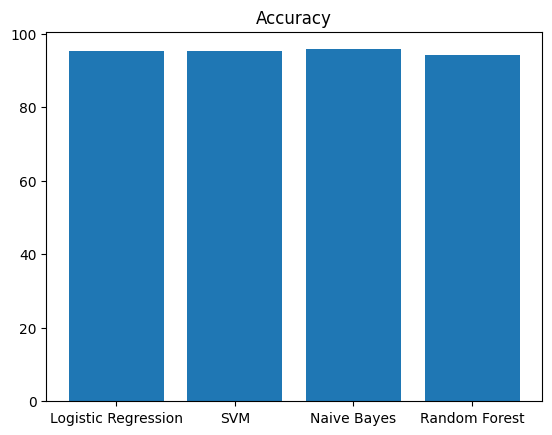

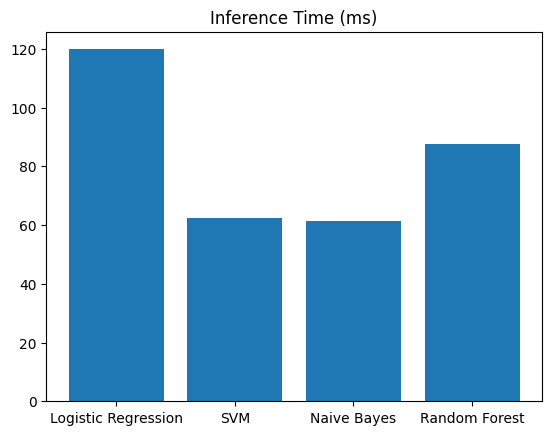

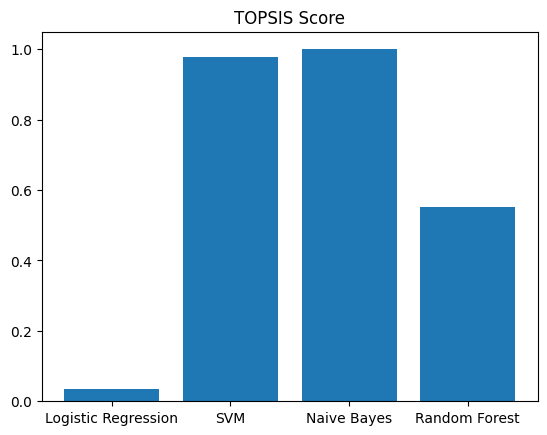

Best Model according to TOPSIS: Naive Bayes


In [1]:
import time
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

data = fetch_20newsgroups(subset='all',
                          categories=['rec.sport.hockey', 'sci.space'],
                          remove=('headers', 'footers', 'quotes'))

X_train, X_test, y_train, y_test = train_test_split(
    data.data, data.target, test_size=0.25, random_state=42
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

results = []

for name, model in models.items():
    pipeline = Pipeline([
        ("tfidf", TfidfVectorizer(stop_words='english', max_features=5000)),
        ("clf", model)
    ])

    start_train = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_train

    start_test = time.time()
    y_pred = pipeline.predict(X_test)
    inference_time = time.time() - start_test

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    size = sys.getsizeof(pipeline) / 1024

    results.append([name, acc*100, f1, inference_time*1000, size])

df = pd.DataFrame(results, columns=[
    "Model", "Accuracy", "F1_score", "Inference_Time", "Model_Size"
])

weights = np.array([0.35, 0.30, 0.20, 0.15])
impacts = ['+', '+', '-', '-']

m = df.iloc[:, 1:].values
norm = m / np.sqrt((m**2).sum(axis=0))
weighted = norm * weights

ib, iw = [], []
for i in range(len(impacts)):
    if impacts[i] == '+':
        ib.append(weighted[:, i].max())
        iw.append(weighted[:, i].min())
    else:
        ib.append(weighted[:, i].min())
        iw.append(weighted[:, i].max())

ib, iw = np.array(ib), np.array(iw)

db = np.sqrt(((weighted - ib) ** 2).sum(axis=1))
dw = np.sqrt(((weighted - iw) ** 2).sum(axis=1))

df["TOPSIS_Score"] = dw / (db + dw)
df["Rank"] = df["TOPSIS_Score"].rank(ascending=False)

print(df.sort_values("Rank"))

plt.bar(df["Model"], df["Accuracy"])
plt.title("Accuracy")
plt.show()

plt.bar(df["Model"], df["Inference_Time"])
plt.title("Inference Time (ms)")
plt.show()

plt.bar(df["Model"], df["TOPSIS_Score"])
plt.title("TOPSIS Score")
plt.show()

best = df.sort_values("Rank").iloc[0]["Model"]
print("Best Model according to TOPSIS:", best)
